### Get OSI SAF SIC at Hausgarten stations, save dataframes

#### Only use on albedo! Needs daily data for monthly SIC std

#### Modules and functions

In [56]:
import numpy as np
import pylab as plt
import xarray as xr
import os,sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import pandas as pd
import datetime
import glob
import math

In [58]:


def haversine(lon1,lat1,lon2,lat2):
    # Radius of the Earth in kilometers. For miles, use 3958.8
    R = 6371.0 

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance



In [2]:
def convert_to_decimal_degrees(coord_str):
    # Remove the degree symbol and split the string
    degree_str, minute_str_with_direction = coord_str.split('°')
    minute_str, direction = minute_str_with_direction.split("'")

    # Remove any commas from the minute string and convert to float
    minutes = float(minute_str.replace(',', '.'))

    # Convert degree string to float
    degrees = float(degree_str)

    # Calculate decimal degrees
    decimal_degrees = degrees + minutes / 60

    # If the direction is 'S' or 'W', make the decimal degrees negative
    if direction.strip() in ['S', 'W']:
        decimal_degrees = -decimal_degrees

    return decimal_degrees

In [49]:
def convert_to_dms(decimal_degrees):
    # Separate the degrees
    degrees = int(decimal_degrees)
    # Calculate the minutes by taking the decimal part of degrees and multiplying by 60
    minutes_full = abs(decimal_degrees - degrees) * 60
    minutes = int(minutes_full)
    # Calculate the seconds by taking the decimal part of minutes and multiplying by 60
    seconds = (minutes_full - minutes) * 60

    return degrees, minutes, seconds

In [3]:
def xydist(x,y,x_2d,y_2d):
    return np.sqrt((x-x_2d)**2 + (y-y_2d)**2)

In [4]:
def XY_To_LatLon(x,y,projstring):
    p1=pyproj.Proj(projstring,preserve_units=True)
    (lat,lon)=p1(x,y,inverse=True,)
    return(lat,lon)

In [5]:
def LatLon_To_XY(lat,lon,projstring):
    p1=pyproj.Proj(projstring,preserve_units=True)
    (x,y)=p1(lat,lon,inverse=False,)
    return(x,y)

In [6]:
def get_coorddicts(df):
    londict = {stationname:np.round(lon,3) for stationname,lon in zip(df["Station ID"],df["lon_decimal"])}
    latdict = {stationname:np.round(lat,3) for stationname,lat in zip(df["Station ID"],df["lat_decimal"])}
    return londict,latdict

In [7]:
def design_map(ax,title,hemisphere):
    if hemisphere == "nh":
        ax.set_extent([-30, 30, 75,85], ccrs.PlateCarree())
    elif hemisphere == "sh":
        ax.set_extent([-180, 180, -60,-90], ccrs.PlateCarree())
    else:
        sys.exit("Hemisphere needs to be either 'nh' or 'sh'!")
    ax.set_title(title,fontsize = 14) # set title
    ax.coastlines()
    ax.gridlines()
    #ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#F5E5A0')  # Adjust facecolor as needed
    #ax.set_facecolor('#F5F5F5')
    #ax.gridlines().label_style = {'fontsize': 14}
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, alpha=0.5, linestyle='--', draw_labels=True)
    #gl.xlabel_style = {'size': 14, 'color': 'black'}
    #gl.ylabel_style = {'size': 14, 'color': 'black'}

In [8]:
def get_dirs():
    if os.path.exists("/Users/vludwig/"):
        basedir = "/Users/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/Users/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        #datadir_nc = os.path.join(basedir,"02_NETCDF/01_MONTHLY")
        datadir_nc = os.path.join(basedir,"02_NETCDF/02_MONTHLY_OWN")
    else:
        basedir = "/albedo/work/user/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/albedo/home/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        datadir_nc = "/albedo/work/user/vludwig/05_SINXS/02_DATA/00_MISC/osisaf/monthly/"
    return basedir,plotdir,datadir_csv,datadir_nc

#### Load data

In [9]:
basedir,plotdir,datadir_csv,datadir_nc = get_dirs()

##### Filenames of OSI SAF data

In [10]:
#fns = list(np.sort([os.path.basename(fn) for fn in glob.glob(os.path.join(datadir_osisaf,"ice_conc_nh*nc"))]))

#### Get coordinates

##### OSI SAF coordinates

In [11]:
coordfile = xr.open_dataset(os.path.join(datadir_nc,"ice_conc_nh_ease2-250_cdr-v3p0_199901.nc")) # can be any file
x_2d,y_2d = np.meshgrid(coordfile.coords["xc"],coordfile.coords["yc"])

In [12]:
x_2d.min()

-5387.5

In [13]:
lon_2d,lat_2d = XY_To_LatLon(x_2d*1e3,y_2d*1e3,projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs")

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_67019/1678578547.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


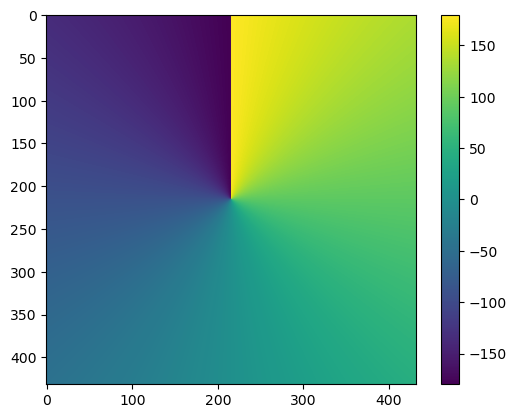

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(lon_2d)
cb = fig.colorbar(im,ax=ax)
fig.show()

In [15]:
projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"

##### Hausgarten coordinates

In [16]:
df_hausgarten = pd.read_excel(os.path.join(datadir_csv,"average HG-Stations.xlsx"))

In [17]:
# Define the list of Station IDs you want to filter by
station_ids = ['EG-I', 'EG-II', 'EG-III', 'EG-IV', 'N3', 'N4', 'N5']

# Select rows where "Station ID" is in the specified list
hausgarten_ice = df_hausgarten[df_hausgarten['Station ID'].isin(station_ids)]
inds = hausgarten_ice.index.to_list()

In [18]:
hausgarten_ice.to_csv(os.path.join(datadir_csv,"hausgarten_ice.csv"))

In [19]:
hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]
hausgarten_ice["color"] = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:hausgarten_ice.shape[0]]

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_67019/1430737232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_67019/1430737232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]
/var/folders/d6/cf68q

In [46]:
londict,latdict = get_coorddicts(hausgarten_ice)

#### Get data

In [69]:
latdict.keys

<function dict.keys>

In [83]:
## BETWEEN SATELLITE PIXELS AND STATIONS ##
# Generate station information
station_ids = ["EG-I","EG-II","EG-III","EG-IV","N3","N4","N5"]
projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"

# Create base columns: Station ID, lon, lat, sic, year, and month
for station_id in station_ids:
    print(f"### {station_id} ###")
    lon_station = londict[station_id]
    lat_station = latdict[station_id]
    x_station_tmp,y_station_tmp = LatLon_To_XY(lon_station,lat_station,projstring)
    x_station = x_station_tmp*1e-3
    y_station = y_station_tmp*1e-3
    dist_station = xydist(x_station, y_station, x_2d,y_2d)
    minind_station = np.where(dist_station == dist_station.min())
    print(f"Lon/Lat station: {lon_station:0.03f}/{lat_station:0.03f}")
    print(f"Lon/Lat OSI SAF: {lon_2d[minind_station][0]:0.03f}/{lat_2d[minind_station][0]:0.03f}")
    print(f"Distance: {haversine(lon_station,lat_station,lon_2d[minind_station][0],lat_2d[minind_station][0]):0.1f} km")
    print("")
    
    #continue



### EG-I ###
Lon/Lat station: -5.371/78.982
Lon/Lat OSI SAF: -5.301/79.080
Distance: 11.0 km

### EG-II ###
Lon/Lat station: -4.647/78.934
Lon/Lat OSI SAF: -4.044/78.874
Distance: 14.5 km

### EG-III ###
Lon/Lat station: -3.915/78.812
Lon/Lat OSI SAF: -4.044/78.874
Distance: 7.4 km

### EG-IV ###
Lon/Lat station: -2.754/78.728
Lon/Lat OSI SAF: -2.834/78.663
Distance: 7.4 km

### N3 ###
Lon/Lat station: 5.196/79.598
Lon/Lat OSI SAF: 5.528/79.528
Distance: 10.3 km

### N4 ###
Lon/Lat station: 4.468/79.734
Lon/Lat OSI SAF: 4.399/79.771
Distance: 4.4 km

### N5 ###
Lon/Lat station: 3.120/79.944
Lon/Lat OSI SAF: 3.215/80.010
Distance: 7.6 km



In [81]:
## BETWEEN STATIONS ##

# Generate station information
station_ids = ["EG-I","EG-II","EG-III","EG-IV","N3","N4","N5"]
projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"

# Create base columns: Station ID, lon, lat, sic, year, and month
print("### DISTANCE BETWEEN STATIONS ###\n")
for i,station_id in enumerate(station_ids):
    if i == (len(station_ids)-1):
        continue
    print(f"### {station_id} to {station_ids[i+1]} ###")
    lon_station = londict[station_id]
    lat_station = latdict[station_id]
    lon_nextstation = londict[station_ids[i+1]]
    lat_nextstation = latdict[station_ids[i+1]]
    print(f"Lon/Lat {station_id}: {lon_station:0.03f}/{lat_station:0.03f}")
    print(f"Lon/Lat {station_ids[i+1]}: {lon_nextstation:0.03f}/{lat_nextstation:0.03f}")
    print(f"Lon/Lat diff: {lon_station-lon_nextstation:0.03f}/{lat_station-lat_nextstation:0.03f}")
    print(f"Distance between {station_id} and {station_ids[i+1]} : {haversine(lon_station,lat_station,lon_nextstation,lat_nextstation):0.1f} km")
    print("")
    
    #continue



### DISTANCE BETWEEN STATIONS ###

### EG-I to EG-II ###
Lon/Lat EG-I: -5.371/78.982
Lon/Lat EG-II: -4.647/78.934
Lon/Lat diff: -0.724/0.048
Distance between EG-I and EG-II : 16.3 km

### EG-II to EG-III ###
Lon/Lat EG-II: -4.647/78.934
Lon/Lat EG-III: -3.915/78.812
Lon/Lat diff: -0.732/0.122
Distance between EG-II and EG-III : 20.8 km

### EG-III to EG-IV ###
Lon/Lat EG-III: -3.915/78.812
Lon/Lat EG-IV: -2.754/78.728
Lon/Lat diff: -1.161/0.084
Distance between EG-III and EG-IV : 26.8 km

### EG-IV to N3 ###
Lon/Lat EG-IV: -2.754/78.728
Lon/Lat N3: 5.196/79.598
Lon/Lat diff: -7.950/-0.870
Distance between EG-IV and N3 : 192.1 km

### N3 to N4 ###
Lon/Lat N3: 5.196/79.598
Lon/Lat N4: 4.468/79.734
Lon/Lat diff: 0.728/-0.136
Distance between N3 and N4 : 21.0 km

### N4 to N5 ###
Lon/Lat N4: 4.468/79.734
Lon/Lat N5: 3.120/79.944
Lon/Lat diff: 1.348/-0.210
Distance between N4 and N5 : 35.3 km



In [21]:
# Define years and months
years = list(range(1999, 2024))
months = [f"{d:02d}" for d in range(1,13)]

# Generate station information
station_ids = hausgarten_ice["Station ID"]

projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"

# Create base columns: Station ID, lon, lat, sic, year, and month
for station_id in station_ids:
    print(f"### {station_id} ###")
    lon_station = londict[station_id]
    lat_station = latdict[station_id]
    x_station_tmp,y_station_tmp = LatLon_To_XY(lon_station,lat_station,projstring)
    x_station = x_station_tmp*1e-3
    y_station = y_station_tmp*1e-3
    dist_station = xydist(x_station, y_station, x_2d,y_2d)
    minind_station = np.where(dist_station == dist_station.min())
    print(minind_station)
    print(lon_station,lat_station)
    print(lon_2d[minind_station],lat_2d[minind_station])
    print("")
    #continue
    data_station = {
        "station_id":np.repeat(station_id,len(years)*12),
        'lon': londict[station_id],
        'lat': latdict[station_id],
        'year': np.repeat(years,len(months)),
        'month': months*len(years),

    }
    
    # Create the DataFrame
    df_station = pd.DataFrame(data_station)
    sic_mean_station,sic_std_station = [],[]
    for year in years:
        print(f"### {year} ###")
        print(f"Time: {datetime.datetime.strftime(datetime.datetime.now(),'%H:%m:%S')}")
        if year <=2020:
            prefix = "ice_conc_nh_ease2-250_cdr-v3p0_"
        else:
            prefix = "ice_conc_nh_ease2-250_icdr-v3p0_"
        print("Loading data...")
        #ds_year = xr.open_mfdataset(f"{datadir_osisaf}{prefix}{year}*nc")
        ds_year = xr.open_mfdataset(os.path.join(datadir_nc,f"{prefix}{year}*nc"))
        #sys.exit()
        print("Extracting station...")
        ds_point = ds_year.isel(xc =minind_station[1], yc = minind_station[0])
        print("Getting mean and standard deviation...")
        #monthly_mean = ds_point['sea_ice_concentration'].resample(time='1ME').mean()
        #monthly_std = ds_point['sea_ice_concentration'].resample(time='1ME').std()
        monthly_mean = ds_point['sea_ice_concentration'].resample(time='1ME').mean()
        monthly_std = ds_point['sea_ice_concentration'].resample(time='1ME').std()
        sys.exit()
        print("Adding to dataframe...")
        df_station.loc[df_station["year"] == year,"sic_mean"] = np.round(monthly_mean.to_numpy().flatten(),3)
        df_station.loc[df_station["year"] == year,"sic_std"] = np.round(monthly_std.to_numpy().flatten(),3)
        print(f"Saving dataframe for {station_id}...")
        df_station.to_csv(os.path.join(datadir_csv,f"hausgarten_sic_mean_std_{station_id}_{years[0]}-{years[-1]}.csv"),index = False)
        # sys.exit()
    




### EG-IV ###
(array([266]), array([213]))
-2.754 78.728
[-2.83411102] [78.66298866]

### 1999 ###
Time: 11:11:12
Loading data...
Extracting station...
Getting mean and standard deviation...


SystemExit: 

/Users/vludwig/opt/anaconda3/envs/sinxs/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [26]:
df_station.loc[df_station["year"] == year,"sic_mean"] = np.round(monthly_mean.to_numpy().flatten(),3)

#### Plot map

In [ ]:
x_eg = [-24.5e4,-10e4, -20.5e4, -4.5e4][::-1] + [3.5e4,12.5e4,21.5e4][::-1]
y_eg = [-13.5e5,-13.5e5,-11e5,-11e5] + [-10e5,-10e5,-10e5]
va = ["top","top","bottom","bottom","bottom","bottom","bottom"]

NameError: name 'x_eg' is not defined

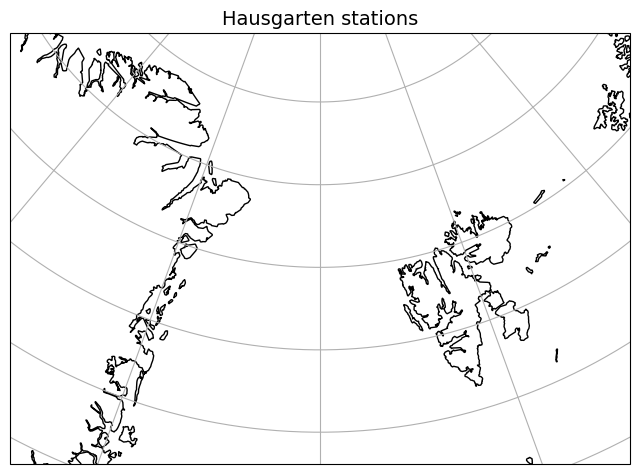

In [109]:
if True:
    fig, ax = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)},figsize=(8,8))

    design_map(ax,title = f"Hausgarten stations", hemisphere="nh")
    for i,station_id in enumerate([16,17,18,19,21,22,23]):
        if hausgarten_ice['Station ID'][station_id].startswith("EG"):
            ax.text(x_eg[i],y_eg[i], hausgarten_ice['Station ID'][station_id], color = "black",va = va[i],ha = "center",bbox=dict(facecolor='salmon', edgecolor='black', boxstyle='round,pad=0.3'))
            x_station,y_station = LatLon_To_XY(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id],projstring=projstring)
            ax.plot([x_station,x_eg[i]],[y_station,y_eg[i]],color = "lightgrey", linestyle = "dashed")
            ax.scatter(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id], transform = ccrs.PlateCarree(),color = "salmon",marker = "d",s = 100,edgecolor = "k",zorder = 99)
        else:
            ax.text(x_eg[i],y_eg[i], hausgarten_ice['Station ID'][station_id], color = "black",va = va[i],ha = "center",bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))
            x_station,y_station = LatLon_To_XY(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id],projstring=projstring)
            ax.plot([x_station,x_eg[i]],[y_station,y_eg[i]],color = "lightgrey", linestyle = "dashed")
            ax.scatter(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id], transform = ccrs.PlateCarree(),color = "lightblue",marker = "d",s = 100,edgecolor = "k",zorder = 99)
    # Add legend (one entry per unique label)
    #ax.legend(ncol = 3)
    cax = ax.pcolormesh(x_2d*1e3,y_2d*1e3,coordfile.ice_conc[0,:,:],cmap = plt.cm.Blues_r)
    fig.colorbar(cax,ax = ax,shrink = .4,label = "Sea-ice concentration")
    fig.show()
    #plt.close(fig)
    #sys.exit()